In [1]:
#!/usr/bin/env python
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from keras.datasets import mnist
import sys

# MNISTNet

In [2]:
class MNISTNet(nn.Module):
    '''
    A CNN with ReLU activations and a three-headed output, two for the 
    actor and one for the critic
    
    y1 - action distribution
    y2 - critic's estimate of value
    
    Input shape:    (batch_size, D_in)
    Output shape:   (batch_size, 40), (batch_size, 1)
    '''
    
    def __init__(self):
        
        super(MNISTNet, self).__init__()
        
        same_padding = (5 - 1) // 2
        
        self.conv1 = nn.Conv2d(1, 10, 5, padding=same_padding)
        self.conv2 = nn.Conv2d(10, 10, 5, padding=same_padding)
        self.lin1  = nn.Linear(10 * 7 * 7, 50)
        
        self.out_dir = nn.Linear(50, 4)
        self.out_digit = nn.Linear(50, 10)
        self.out_critic = nn.Linear(50, 1)
    
    def forward(self, x):
    
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(2)(x)
        
        x = x.view(-1, 10 * 7 * 7)
        x = self.lin1(x)
        
        pi1 = self.out_digit(x)
        pi1 = F.softmax(pi1, dim=-1)
        
        pi2 = self.out_dir(x)
        pi2 = F.softmax(pi2, dim=-1)
        
        # https://discuss.pytorch.org/t/batch-outer-product/4025
        y1 = torch.bmm(pi1.unsqueeze(2), pi2.unsqueeze(1))
        y1 = y1.view(-1, 40)
        
        y2 = self.out_critic(x)
        
        return y1, y2

def torch_to_numpy(tensor):
    return tensor.data.numpy()

def numpy_to_torch(array):
    return torch.tensor(array).float()

class ActorCriticNNAgent:
    '''
    Neural-net agent that trains using the actor-critic algorithm. The critic 
    is a value function that returns expected discounted reward given the
    state as input. We use advantage defined as
    
        A = r + g * V(s') - V(s)
        
    Notation:
        A - advantage
        V - value function
        r - current reward
        g - discount factor
        s - current state
        s' - next state
    '''
    
    def __init__(self, new_network, params=None, obs_to_input=lambda x: x, 
                 lr=1e-3, df=0.5, alpha=0.5):
    
        # model and parameters
        if params is not None:
            self.model = new_network(params)
        else:
            self.model = new_network()
        if isinstance(self.model, torch.nn.Module):
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.df = df # discount factor
        self.alpha = alpha # multiply critic updates by this factor
        
        # initialize replay history
        self.replay = []
        
        # function that converts observation into input of dimension D_in
        self.obs_to_input = obs_to_input
        
        # if trainable is changed to false, the model won't be updated
        self.trainable = True
    
    def act(self, o, env=None, display=False):
        
        # feed observation as input to net to get distribution as output
        x = self.obs_to_input(o)
        x = numpy_to_torch([x])
        y1, y2 = self.model(x)
        
        pi = torch_to_numpy(y1).flatten()
        v  = torch_to_numpy(y2).squeeze()
        
        # sample action from distribution
        a = np.random.choice(np.arange(40), p=pi)
        
        if display:
            direction, digit = a % 4, a // 4
            pi1 = pi.reshape((10, 4)).sum(axis=0)
            pi2 = pi.reshape((10, 4)).sum(axis=1)
            
            print("")
            print("Sampled action:", (direction, digit))
            print("Value estimate:", v) 
            print("Distributions:", pi1, pi2, sep='\n')
        
        # update current episode in replay with observation and chosen action
        if self.trainable:
            self.replay[-1]['observations'].append(o)
            self.replay[-1]['actions'].append(a)
        
        return np.array(a)
    
    def new_episode(self):
        # start a new episode in replay
        self.replay.append({'observations': [], 'actions': [], 'rewards': []})
    
    def store_reward(self, r):
        # insert 0s for actions that received no reward; end with reward r
        episode = self.replay[-1]
        T_no_reward = len(episode['actions']) - len(episode['rewards']) - 1
        episode['rewards'] += [0.0] * T_no_reward + [r]
    
    def _calculate_discounted_rewards(self):
        # calculate and store discounted rewards per episode
        
        for episode in self.replay:
            
            R = episode['rewards']
            R_disc = []
            R_sum = 0
            for r in R[::-1]:
                R_sum = r + self.df * R_sum
                R_disc.insert(0, R_sum)
                
            episode['rewards_disc'] = R_disc
    
    def update(self):
        
        assert(self.trainable)
        
        episode_losses = torch.tensor(0.0)
        N = len(self.replay)
        self._calculate_discounted_rewards()
        
        for episode in self.replay:

            O = episode['observations']
            A = episode['actions']
            R = numpy_to_torch(episode['rewards'])
            R_disc = numpy_to_torch(episode['rewards_disc'])
            T = len(R_disc)
            
            # forward pass, Y1 is pi(a | s), Y2 is V(s)
            X = numpy_to_torch([self.obs_to_input(o) for o in O])
            Y1, Y2 = self.model(X)
            pi = Y1
            Vs_curr = Y2.view(-1)
            
            # log probabilities of selected actions
            log_prob = torch.log(pi[np.arange(T), A])
            
            # advantage of selected actions over expected reward given state
            Vs_next = torch.cat((Vs_curr[1:], torch.tensor([0.])))
            adv = R + self.df * Vs_next - Vs_curr
            
            # ignore gradients so the critic isn't affected by actor loss
            adv = adv.detach()
            
            # actor loss is -1 * advantage-weighted sum of log likelihood
            # critic loss is the SE between values and discounted rewards
            actor_loss = -torch.dot(log_prob, adv)
            critic_loss = torch.sum((R_disc - Vs_curr) ** 2)
            episode_losses += actor_loss + critic_loss * self.alpha
            
        # backward pass
        self.optimizer.zero_grad()
        loss = episode_losses / N
        loss.backward()
        self.optimizer.step()
        
        # reset the replay history
        self.replay = []
    
    def copy(self):
        
        # create a copy of this agent with frozen weights
        agent = ActorCriticNNAgent(lambda x: 0, 0, self.obs_to_input)
        agent.model = copy.deepcopy(self.model)
        agent.trainable = False
        for param in agent.model.parameters():
            param.requires_grad = False
            
        return agent

# MNIST env

In [3]:
MAX_STEPS = 20
WINDOW_SIZE = 7
RANDOM_LOC = False

'''
Notes:
    Agent navigation for image classification. We propose
    an image classification task starting with a masked image
    where the agent starts at a random location on the image. It
    can unmask windows of the image by moving in one of 4 directions: 
    {UP, DOWN, LEFT, RIGHT}. At each timestep it
    also outputs a probability distribution over possible classes
    C. The episode ends when the agent correctly classifies the
    image or a maximum of 20 steps is reached. The agent receives a 
    -0.1 reward at each timestep that it misclassifies the
    image. The state received at each time step is the full image
    with unobserved parts masked out.

    -- for now, agent outputs direction of movement and class prediction (0-9)
    -- correct guess ends game
'''

class MNISTEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, type='train', seed=2069):
        
        if seed:
            np.random.seed(seed=seed)
        
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        
        if type == 'train':
            self.X = x_train
            self.Y = y_train
            self.n = len(y_train)
            
        elif type == 'test':
            self.X = x_test
            self.Y = y_test
            self.n = len(y_test)
            
        h, w = self.X[0].shape
        self.h = h // WINDOW_SIZE
        self.w = w // WINDOW_SIZE
        
        self.mask = np.zeros((h, w))
        
        # action is an integer in {0, ..., 39}
        # see 'step' for interpretation
        self.action_space = spaces.Discrete(40)
        self.observation_space = spaces.Box(0, 255, [h, w])
        
    def step(self, action):
    
        # action a consists of
        #   1. direction in {N, S, E, W}, determined by = a (mod 4)
        #   2. predicted class (0-9), determined by floor(a / 4)
        assert(self.action_space.contains(action))
        dir, Y_pred = action % 4, action // 4
        
        self.steps += 1
        
        move_map = {
            0: [-1, 0], # N
            1: [1, 0],  # S
            2: [0, 1],  # E
            3: [0, -1]  # W
        }
        
        # make move and reveal square
        self.pos = np.clip(self.pos + move_map[dir], 0, [self.h-1, self.w-1])
        self._reveal()
        
        # state (observation) consists of masked image (h x w)
        obs = self._get_obs()
        
        # -0.1 penalty for each additional timestep
        # +1.0 for correct guess
        reward = -0.1 + int(Y_pred == self.Y[self.i])
        
        # game ends if prediction is correct or max steps is reached
        done = Y_pred == self.Y[self.i] or self.steps >= MAX_STEPS
        
        # info is empty (for now)
        info = {}
        
        return obs, reward, done, info
        
    def reset(self):
        # resets the environment and returns initial observation
        # zero the mask, move to random location, and choose new image
        
        # initialize at random location or image center
        if RANDOM_LOC:
            self.pos = np.array([np.random.randint(self.h), 
                                 np.random.randint(self.w)])
        else:
            self.pos = np.array([int(self.h / 2), int(self.w / 2)])
            
        self.mask[:, :] = 0
        self._reveal()
        self.i = np.random.randint(self.n)
        self.steps = 0
        
        return self._get_obs()
        
    def _get_obs(self):
        obs = self.X[self.i] * self.mask / 255
        #obs = self.X[self.i] * self.mask 
        #assert self.observation_space.contains(obs)
        return obs
        
    def _reveal(self):
        # reveal the window at self.pos
        h, w = self.pos
        h_low, h_high = h * WINDOW_SIZE, (h + 1) * WINDOW_SIZE
        w_low, w_high = w * WINDOW_SIZE, (w + 1) * WINDOW_SIZE
        
        self.mask[h_low:h_high, w_low:w_high] = 1
        
    def render(self, mode='human', close=False):
        # display mask, full image, and masked image
        
        plt.figure(figsize=(10, 3))
        plt.suptitle("Step %d" % self.steps)
        
        plt.subplot(131)
        plt.imshow(255 * self.mask)
        plt.subplot(132)
        plt.imshow(self.X[self.i])
        plt.subplot(133)
        plt.imshow(self.X[self.i] * self.mask)
        
        plt.show()

# Train, test, eval

In [4]:
def obs_to_input(obs):
        # reshape to (1, 28, 28)
        return obs[np.newaxis, ...]

In [5]:
def train(iterations, episodes, verbose=False):
    ''' Method to train a model, currently fixed on
    using ActorCritic; will change when updated to use
    modular DeepRL env'''
    
    all_iter_reward = []
    
    # initialize agent
    agent = ActorCriticNNAgent(MNISTNet, obs_to_input=obs_to_input, df=0.1)
    
    # intialize environment
    env = MNISTEnv(type='train', seed=None)
    
    # training loop
    start = time.time()
    for iter in range(iterations):
    
        if iter % 50 == 0: print("Starting iteration %d" % iter)
        rewards = []
    
        # play out each episode
        for ep in range(episodes):
        
            if verbose and iter % 1000 == 0 and ep == 0:
                display = True
            else:
                display = False
            
            observation = env.reset()
            agent.new_episode()
            total_reward = 0
            
            done = False
            while not done:
                    
                action = agent.act(observation, env, display=display)
                observation, reward, done, info = env.step(action)
                
                if display: print("Actual reward:", reward)
                agent.store_reward(reward)
                total_reward += reward
            
            rewards.append(total_reward)
            
            if display: 
                env.render()
                action = env.action_space.sample()
                dir, Y_pred = action % 4, action // 4
                print("Agent moved %s" % (['North', 'South', 'East', 'West'][dir]))
                print("Agent guessed %d" % Y_pred)
    
            
        # adjust agent parameters based on played episodes
        agent.update()
        
        # print performance for this iteration
        
        if iter % 100 == 0:
            mean_total_reward = np.mean(rewards)
            all_iter_reward.append(mean_total_reward)
            print("Mean total reward / episode: %.3f" % mean_total_reward)
        
    end = time.time()
    print("Completed %d iterations of %d episodes in %.3f s" % \
          (iterations, episodes, end - start))
        
    # return trained agent
    return agent, all_iter_reward
    
    
def eval(agent, n_test=1000):
    # evaluate a trained agent
    
    env = MNISTEnv(type='test', seed=None)
    
    observation = env.reset()
    
    done = False
    while not done:
        
        action = agent.act(observation, env, display=True)
        observation, reward, done, info = env.step(action)
        
        print("Received reward %.1f on step %d" % (reward, env.steps))
        env.render()
    
    
def test(agent, n_test=1000):
    # calculate test average reward
    
    env = MNISTEnv(type='test', seed=None)
    
    rewards = []
    for _ in range(n_test):
    
        observation = env.reset()
        total_reward = 0
        
        done = False
        while not done:
                
            action = agent.act(observation, env, display=False)
            observation, reward, done, info = env.step(action)
            
            total_reward += reward
        
        rewards.append(total_reward)
    
    print("Mean total reward / episode: %.3f" % np.mean(rewards))

# Check env

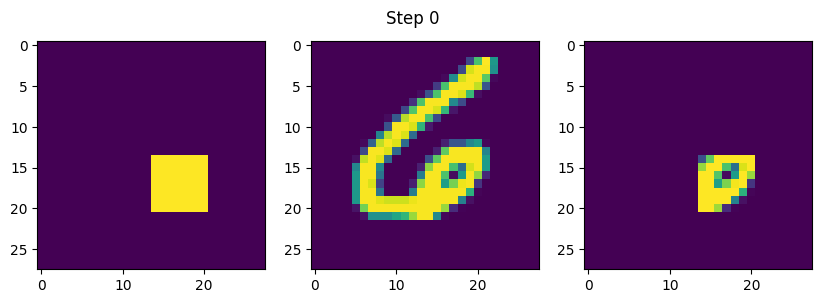

Agent moved South
Agent guessed 9
Received reward -0.1 on step 1


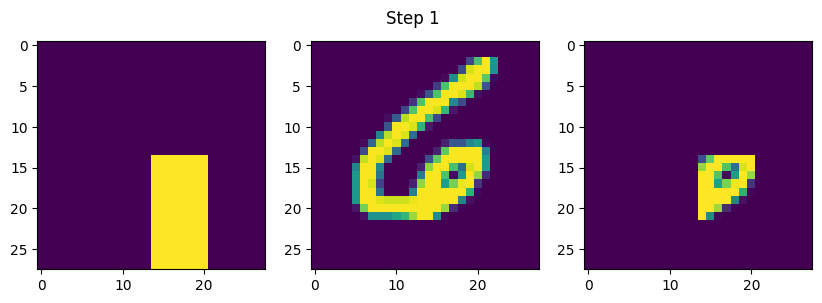

Agent moved North
Agent guessed 4
Received reward -0.1 on step 2


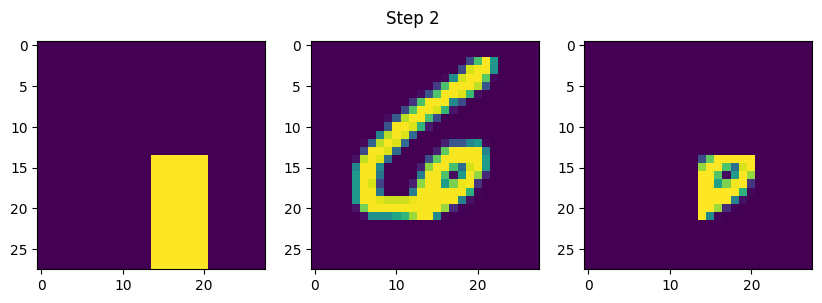

Agent moved South
Agent guessed 1
Received reward -0.1 on step 3


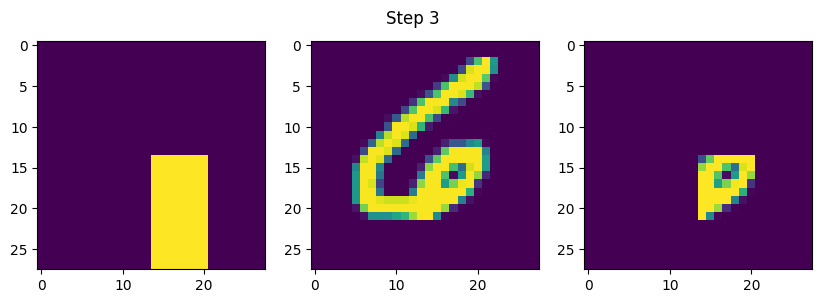

Agent moved North
Agent guessed 8
Received reward -0.1 on step 4


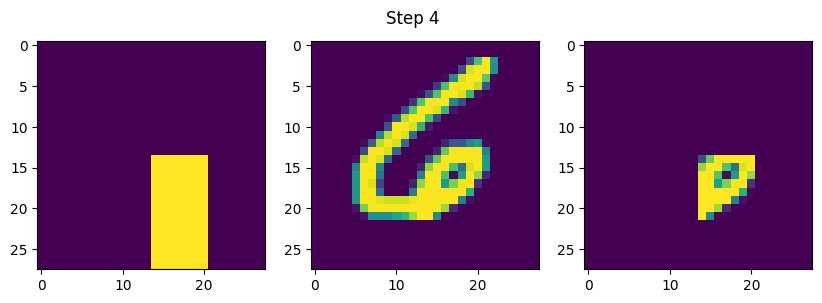

Agent moved West
Agent guessed 3
Received reward -0.1 on step 5


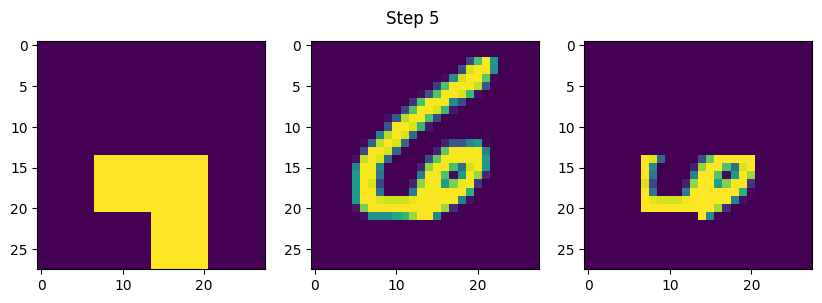

Agent moved North
Agent guessed 7
Received reward -0.1 on step 6


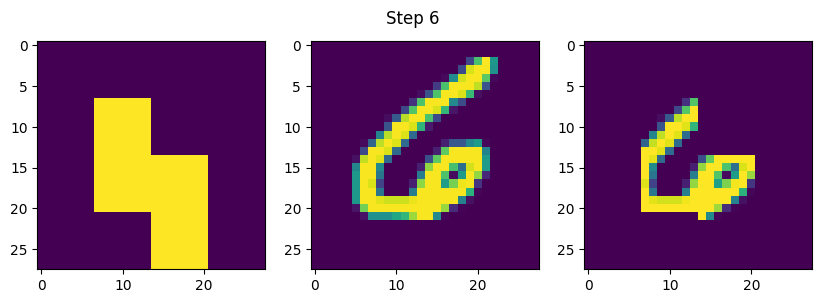

Agent moved South
Agent guessed 8
Received reward -0.1 on step 7


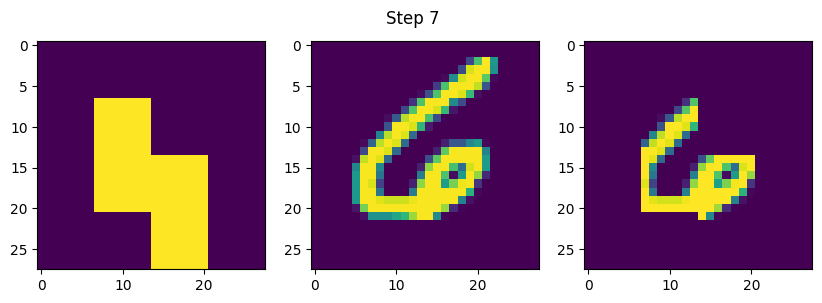

Agent moved East
Agent guessed 4
Received reward -0.1 on step 8


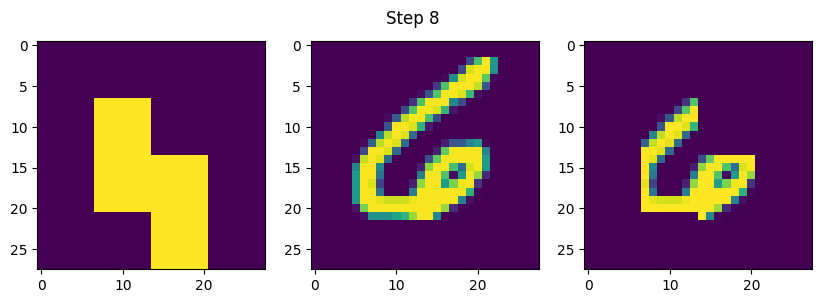

Agent moved East
Agent guessed 6
Received reward 0.9 on step 9


In [49]:
env = MNISTEnv(type='train', seed=None)

obs = env.reset()
done = False

while not done:

    env.render()
    action = env.action_space.sample()
    dir, Y_pred = action % 4, action // 4
    print("Agent moved %s" % (['North', 'South', 'East', 'West'][dir]))
    print("Agent guessed %d" % Y_pred)
    
    _, reward, done, _ = env.step(action)
    print("Received reward %.1f on step %d" % (reward, env.steps))

# Main

Training...
Starting iteration 0

Sampled action: (2, 2)
Value estimate: 0.016866116
Distributions:
[0.23086467 0.3029991  0.20870699 0.25742924]
[0.08528428 0.09722088 0.09835862 0.11278939 0.09312996 0.10396098
 0.11048901 0.11236169 0.1019388  0.08446641]
Actual reward: -0.1

Sampled action: (0, 2)
Value estimate: 0.016866116
Distributions:
[0.23086467 0.3029991  0.20870699 0.25742924]
[0.08528428 0.09722088 0.09835862 0.11278939 0.09312996 0.10396098
 0.11048901 0.11236169 0.1019388  0.08446641]
Actual reward: -0.1

Sampled action: (1, 8)
Value estimate: 0.016866116
Distributions:
[0.23086467 0.3029991  0.20870699 0.25742924]
[0.08528428 0.09722088 0.09835862 0.11278939 0.09312996 0.10396098
 0.11048901 0.11236169 0.1019388  0.08446641]
Actual reward: -0.1

Sampled action: (1, 2)
Value estimate: 0.016866116
Distributions:
[0.23086467 0.3029991  0.20870699 0.25742924]
[0.08528428 0.09722088 0.09835862 0.11278939 0.09312996 0.10396098
 0.11048901 0.11236169 0.1019388  0.08446641]
Act

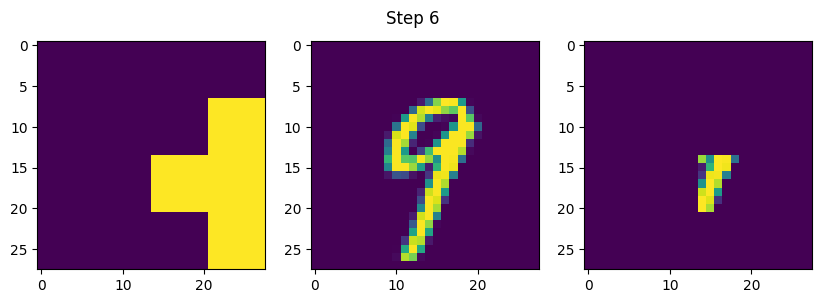

Agent moved South
Agent guessed 3
Mean total reward / episode: -0.003
Starting iteration 50
Starting iteration 100
Mean total reward / episode: 0.381
Starting iteration 150
Starting iteration 200
Mean total reward / episode: 0.503
Starting iteration 250
Starting iteration 300
Mean total reward / episode: 0.681
Starting iteration 350
Starting iteration 400
Mean total reward / episode: 0.156
Starting iteration 450
Starting iteration 500
Mean total reward / episode: 0.334
Starting iteration 550
Starting iteration 600
Mean total reward / episode: 0.156
Starting iteration 650
Starting iteration 700
Mean total reward / episode: 0.700
Starting iteration 750
Starting iteration 800
Mean total reward / episode: 0.394
Starting iteration 850
Starting iteration 900
Mean total reward / episode: 0.694
Starting iteration 950
Starting iteration 1000

Sampled action: (1, 0)
Value estimate: 0.1376137
Distributions:
[6.9337457e-06 9.9998456e-01 8.2512170e-06 2.2603191e-07]
[9.3544352e-01 2.7761118e-11 2.1

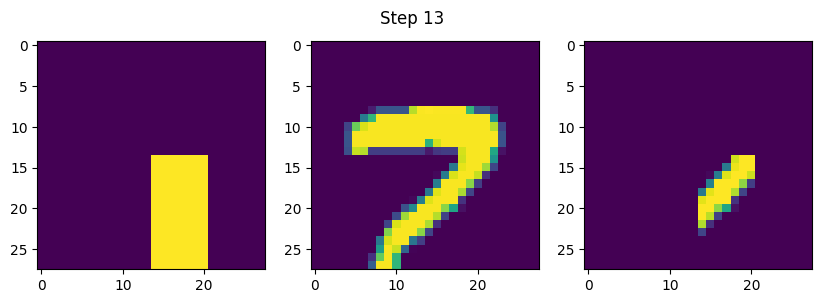

Agent moved West
Agent guessed 2
Mean total reward / episode: 0.391
Starting iteration 1050
Starting iteration 1100
Mean total reward / episode: 0.437
Starting iteration 1150
Starting iteration 1200
Mean total reward / episode: 0.653
Starting iteration 1250
Starting iteration 1300
Mean total reward / episode: 0.469
Starting iteration 1350
Starting iteration 1400
Mean total reward / episode: 0.609
Starting iteration 1450
Starting iteration 1500
Mean total reward / episode: 0.569
Starting iteration 1550
Starting iteration 1600
Mean total reward / episode: 0.456
Starting iteration 1650
Starting iteration 1700
Mean total reward / episode: 0.644
Starting iteration 1750
Starting iteration 1800
Mean total reward / episode: 0.847
Starting iteration 1850
Starting iteration 1900
Mean total reward / episode: 0.506
Starting iteration 1950
Starting iteration 2000

Sampled action: (1, 5)
Value estimate: 0.2718423
Distributions:
[1.3397427e-03 9.9711984e-01 4.7134593e-04 1.0691377e-03]
[3.9564038e-06

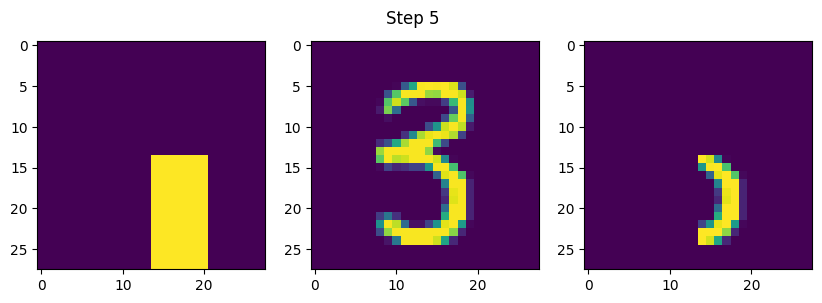

Agent moved East
Agent guessed 2
Mean total reward / episode: 0.584
Starting iteration 2050
Starting iteration 2100
Mean total reward / episode: 0.675
Starting iteration 2150
Starting iteration 2200
Mean total reward / episode: 0.631
Starting iteration 2250
Starting iteration 2300
Mean total reward / episode: 0.588
Starting iteration 2350
Starting iteration 2400
Mean total reward / episode: 0.722
Starting iteration 2450
Starting iteration 2500
Mean total reward / episode: 0.656
Starting iteration 2550
Starting iteration 2600
Mean total reward / episode: 0.597
Starting iteration 2650
Starting iteration 2700
Mean total reward / episode: 0.622
Starting iteration 2750
Starting iteration 2800
Mean total reward / episode: 0.584
Starting iteration 2850
Starting iteration 2900
Mean total reward / episode: 0.656
Starting iteration 2950
Starting iteration 3000

Sampled action: (1, 8)
Value estimate: 0.57566196
Distributions:
[0.01149312 0.9411645  0.00490184 0.0424406 ]
[6.4720712e-06 3.5796665e

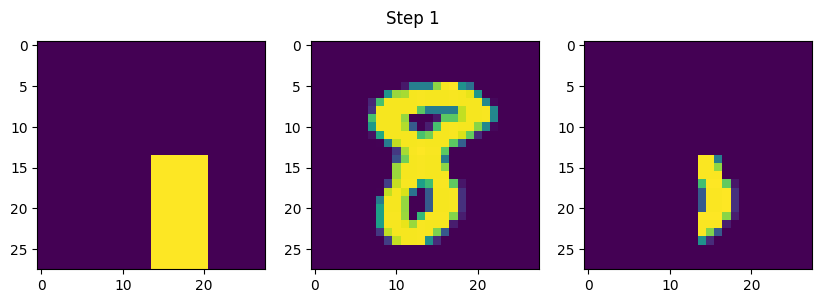

Agent moved South
Agent guessed 8
Mean total reward / episode: 0.619
Starting iteration 3050
Starting iteration 3100
Mean total reward / episode: 0.347
Starting iteration 3150
Starting iteration 3200
Mean total reward / episode: 0.659
Starting iteration 3250
Starting iteration 3300
Mean total reward / episode: 0.469
Starting iteration 3350
Starting iteration 3400
Mean total reward / episode: 0.634
Starting iteration 3450
Starting iteration 3500
Mean total reward / episode: 0.509
Starting iteration 3550
Starting iteration 3600
Mean total reward / episode: 0.597
Starting iteration 3650
Starting iteration 3700
Mean total reward / episode: 0.394
Starting iteration 3750
Starting iteration 3800
Mean total reward / episode: 0.591
Starting iteration 3850
Starting iteration 3900
Mean total reward / episode: 0.497
Starting iteration 3950
Starting iteration 4000

Sampled action: (1, 1)
Value estimate: 0.44353613
Distributions:
[6.8563371e-05 9.9953985e-01 1.7126222e-05 3.7445634e-04]
[5.4957962e-

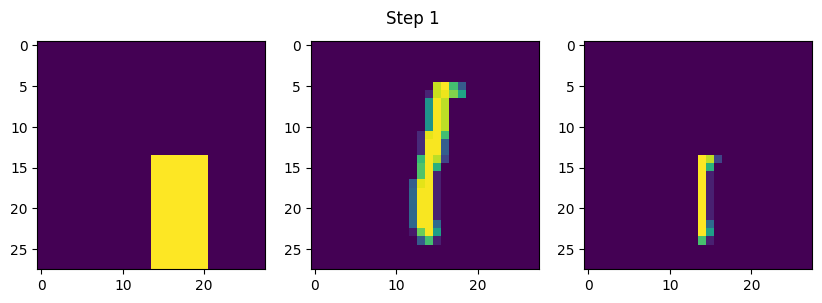

Agent moved North
Agent guessed 0
Mean total reward / episode: 0.384
Starting iteration 4050
Starting iteration 4100
Mean total reward / episode: 0.625
Starting iteration 4150
Starting iteration 4200
Mean total reward / episode: 0.728
Starting iteration 4250
Starting iteration 4300
Mean total reward / episode: 0.856
Starting iteration 4350
Starting iteration 4400
Mean total reward / episode: 0.716
Starting iteration 4450
Starting iteration 4500
Mean total reward / episode: 0.541
Starting iteration 4550
Starting iteration 4600
Mean total reward / episode: 0.713
Starting iteration 4650
Starting iteration 4700
Mean total reward / episode: 0.716
Starting iteration 4750
Starting iteration 4800
Mean total reward / episode: 0.731
Starting iteration 4850
Starting iteration 4900
Mean total reward / episode: 0.784
Starting iteration 4950
Starting iteration 5000

Sampled action: (1, 0)
Value estimate: 0.48806125
Distributions:
[6.3426334e-05 9.9993408e-01 8.5211440e-07 1.6932569e-06]
[8.8990092e-

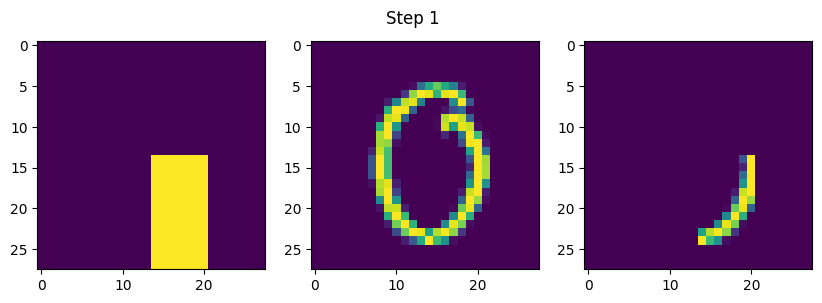

Agent moved North
Agent guessed 3
Mean total reward / episode: 0.481
Starting iteration 5050
Starting iteration 5100
Mean total reward / episode: 0.569
Starting iteration 5150
Starting iteration 5200
Mean total reward / episode: 0.316
Starting iteration 5250
Starting iteration 5300
Mean total reward / episode: 0.706
Starting iteration 5350
Starting iteration 5400
Mean total reward / episode: 0.766
Starting iteration 5450
Starting iteration 5500
Mean total reward / episode: 0.587
Starting iteration 5550
Starting iteration 5600
Mean total reward / episode: 0.762
Starting iteration 5650
Starting iteration 5700
Mean total reward / episode: 0.672
Starting iteration 5750
Starting iteration 5800
Mean total reward / episode: 0.587
Starting iteration 5850
Starting iteration 5900
Mean total reward / episode: 0.447
Starting iteration 5950
Starting iteration 6000

Sampled action: (1, 2)
Value estimate: 0.4714942
Distributions:
[8.7394903e-04 9.9753821e-01 4.0970615e-04 1.1782002e-03]
[2.0060168e-0

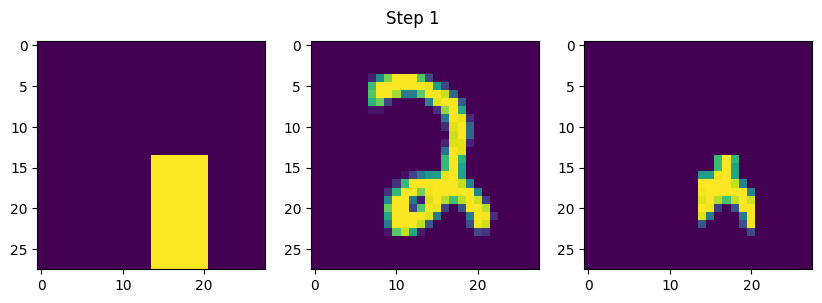

Agent moved West
Agent guessed 8
Mean total reward / episode: 0.537
Starting iteration 6050
Starting iteration 6100
Mean total reward / episode: 0.559
Starting iteration 6150
Starting iteration 6200
Mean total reward / episode: 0.666
Starting iteration 6250
Starting iteration 6300
Mean total reward / episode: 0.731
Starting iteration 6350
Starting iteration 6400
Mean total reward / episode: 0.691
Starting iteration 6450
Starting iteration 6500
Mean total reward / episode: 0.681
Starting iteration 6550
Starting iteration 6600
Mean total reward / episode: 0.578
Starting iteration 6650
Starting iteration 6700
Mean total reward / episode: 0.616
Starting iteration 6750
Starting iteration 6800
Mean total reward / episode: 0.481
Starting iteration 6850
Starting iteration 6900
Mean total reward / episode: 0.541
Starting iteration 6950
Starting iteration 7000

Sampled action: (1, 9)
Value estimate: 0.3027021
Distributions:
[0.05963604 0.887184   0.01313091 0.04004905]
[1.2903108e-03 5.8234618e-

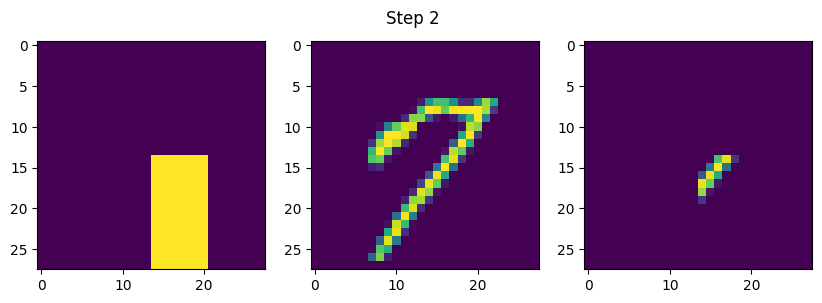

Agent moved North
Agent guessed 7
Mean total reward / episode: 0.644
Starting iteration 7050
Starting iteration 7100
Mean total reward / episode: 0.622
Starting iteration 7150
Starting iteration 7200
Mean total reward / episode: 0.631
Starting iteration 7250
Starting iteration 7300
Mean total reward / episode: 0.572
Starting iteration 7350
Starting iteration 7400
Mean total reward / episode: 0.641
Starting iteration 7450
Starting iteration 7500
Mean total reward / episode: 0.512
Starting iteration 7550
Starting iteration 7600
Mean total reward / episode: 0.684
Starting iteration 7650
Starting iteration 7700
Mean total reward / episode: 0.409
Starting iteration 7750
Starting iteration 7800
Mean total reward / episode: 0.716
Starting iteration 7850
Starting iteration 7900
Mean total reward / episode: 0.787
Starting iteration 7950
Starting iteration 8000

Sampled action: (2, 0)
Value estimate: 0.22086138
Distributions:
[0.01102729 0.05045817 0.92837137 0.01014306]
[7.0775473e-01 5.2352470

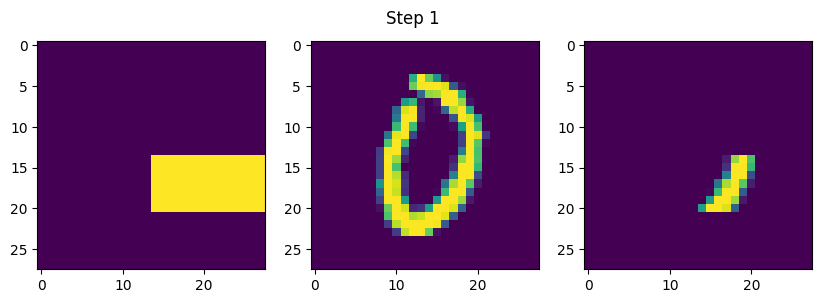

Agent moved North
Agent guessed 9
Mean total reward / episode: 0.544
Starting iteration 8050
Starting iteration 8100
Mean total reward / episode: 0.700
Starting iteration 8150
Starting iteration 8200
Mean total reward / episode: 0.569
Starting iteration 8250
Starting iteration 8300
Mean total reward / episode: 0.725
Starting iteration 8350
Starting iteration 8400
Mean total reward / episode: 0.625
Starting iteration 8450
Starting iteration 8500
Mean total reward / episode: 0.662
Starting iteration 8550
Starting iteration 8600
Mean total reward / episode: 0.463
Starting iteration 8650
Starting iteration 8700
Mean total reward / episode: 0.734
Starting iteration 8750
Starting iteration 8800
Mean total reward / episode: 0.475
Starting iteration 8850
Starting iteration 8900
Mean total reward / episode: 0.525
Starting iteration 8950
Starting iteration 9000

Sampled action: (3, 1)
Value estimate: 0.22496575
Distributions:
[0.01793125 0.0020761  0.11033316 0.86965954]
[1.4348059e-04 9.4488049

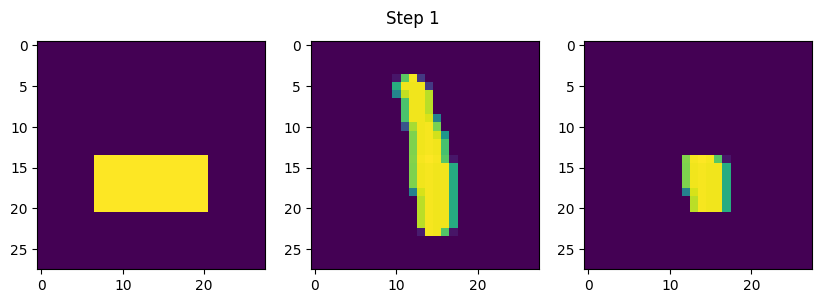

Agent moved North
Agent guessed 2
Mean total reward / episode: 0.634
Starting iteration 9050
Starting iteration 9100
Mean total reward / episode: 0.713
Starting iteration 9150
Starting iteration 9200
Mean total reward / episode: 0.475
Starting iteration 9250
Starting iteration 9300
Mean total reward / episode: 0.456
Starting iteration 9350
Starting iteration 9400
Mean total reward / episode: 0.666
Starting iteration 9450
Starting iteration 9500
Mean total reward / episode: 0.675
Starting iteration 9550
Starting iteration 9600
Mean total reward / episode: 0.628
Starting iteration 9650
Starting iteration 9700
Mean total reward / episode: 0.731
Starting iteration 9750
Starting iteration 9800
Mean total reward / episode: 0.841
Starting iteration 9850
Starting iteration 9900
Mean total reward / episode: 0.587
Starting iteration 9950
Completed 10000 iterations of 32 episodes in 2808.379 s
Testing...
Mean total reward / episode: 0.619
Evaluating...

Sampled action: (2, 0)
Value estimate: 0.44

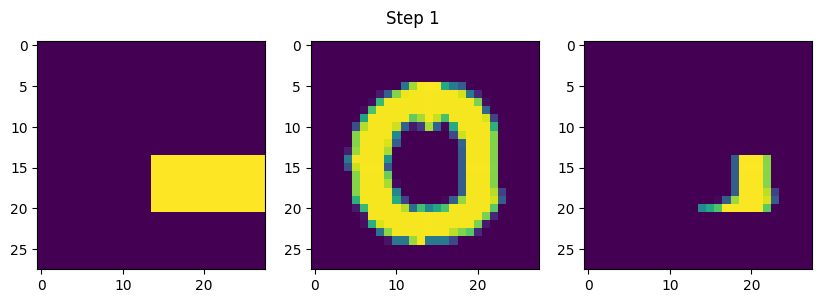


Sampled action: (2, 4)
Value estimate: 0.1732603
Distributions:
[0.02808564 0.00325614 0.9613437  0.00731447]
[4.2545213e-04 1.8835298e-07 5.0891582e-03 8.1307640e-05 8.5612965e-01
 6.3739690e-06 3.6337585e-04 2.0437095e-02 1.5258986e-03 1.1594142e-01]
Received reward 0.9 on step 1


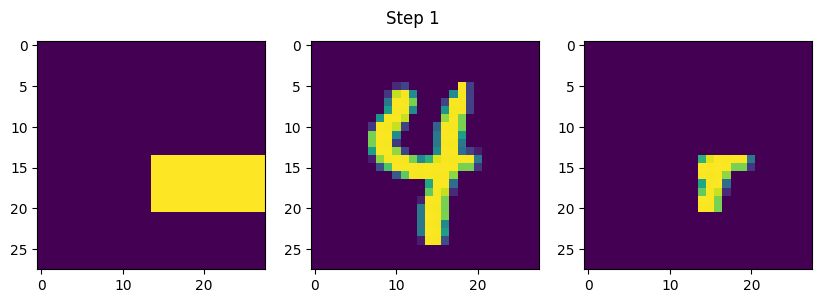


Sampled action: (2, 4)
Value estimate: 0.08749452
Distributions:
[0.04974332 0.00310917 0.9460444  0.00110306]
[2.0750475e-05 1.0900798e-09 1.4989534e-04 5.1079644e-04 2.7267700e-01
 1.5271395e-04 1.4405669e-05 1.9286017e-05 3.1174810e-04 7.2614330e-01]
Received reward -0.1 on step 1


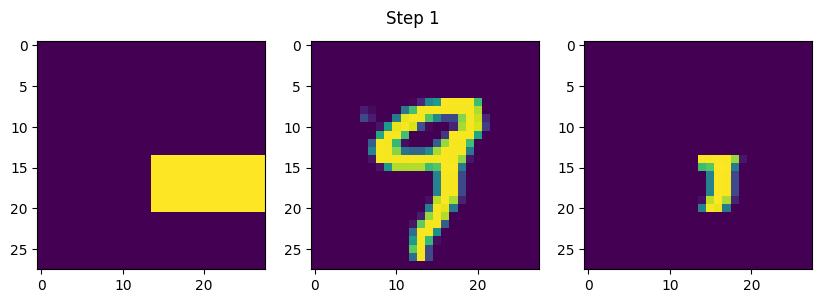


Sampled action: (2, 9)
Value estimate: 0.08749452
Distributions:
[0.04974332 0.00310917 0.9460444  0.00110306]
[2.0750475e-05 1.0900798e-09 1.4989534e-04 5.1079644e-04 2.7267700e-01
 1.5271395e-04 1.4405669e-05 1.9286017e-05 3.1174810e-04 7.2614330e-01]
Received reward 0.9 on step 2


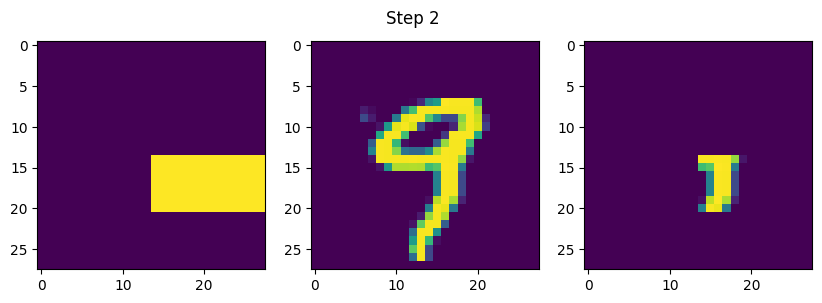


Sampled action: (2, 9)
Value estimate: 0.21253519
Distributions:
[0.07008749 0.0048957  0.90299666 0.02202011]
[8.7857526e-04 6.4532315e-07 1.6598096e-04 7.9716265e-05 8.9940034e-02
 1.2020054e-05 9.1259979e-05 5.2078895e-02 1.5285576e-03 8.5522431e-01]
Received reward 0.9 on step 1


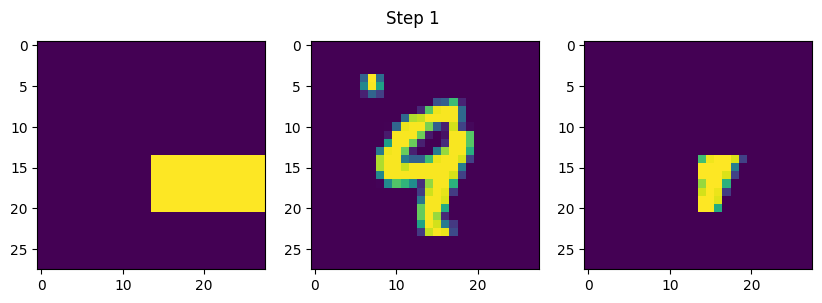


Sampled action: (2, 2)
Value estimate: 0.22747804
Distributions:
[0.03562937 0.00951267 0.9497434  0.00511456]
[7.4332966e-05 4.5966708e-06 9.6146691e-01 4.0973024e-04 7.3160767e-03
 2.0300709e-04 1.7787137e-03 2.6567694e-04 2.2690473e-02 5.7904380e-03]
Received reward 0.9 on step 1


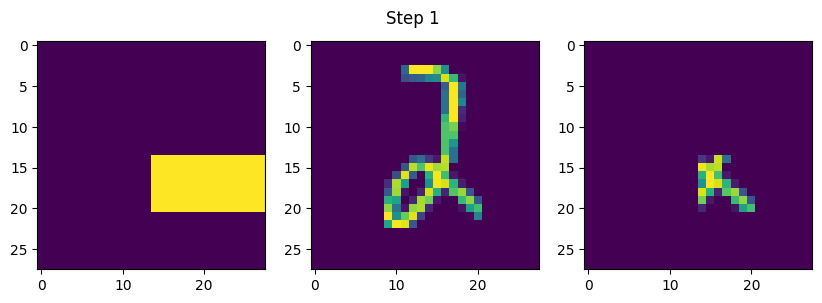

In [50]:
print("Training...")
trained_agent, reward = train(10000, 32, verbose='store_true')
test_agent = trained_agent.copy()

print("Testing...")
test(test_agent)

print("Evaluating...")
for _ in range(5):
    eval(test_agent)


Evaluating...

Sampled action: (0, 9)
Value estimate: 0.22901455
Distributions:
[4.7474921e-02 7.7865496e-03 9.4405693e-01 6.8150659e-04]
[1.2709969e-04 2.5451941e-10 2.5498530e-05 8.9431560e-06 1.5624832e-01
 4.5907668e-06 1.4101464e-03 1.3400664e-04 6.7455672e-05 8.4197384e-01]
Received reward 0.9 on step 1


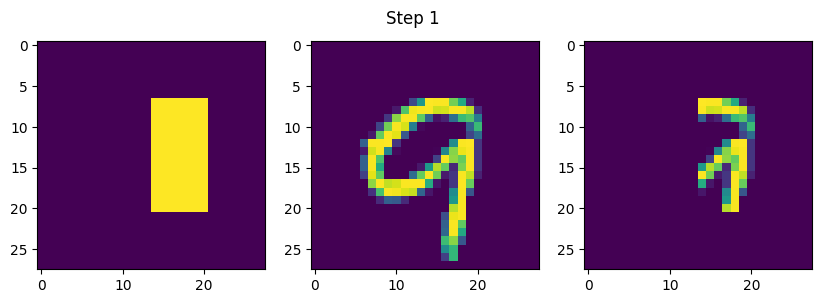


Sampled action: (2, 9)
Value estimate: -0.04288937
Distributions:
[5.1537999e-03 9.3627777e-03 9.8501116e-01 4.7224201e-04]
[6.0513392e-03 2.4061288e-08 5.9886725e-04 1.1385667e-02 7.2057122e-01
 1.4755973e-02 5.3383112e-02 1.9182412e-02 2.6917586e-03 1.7137960e-01]
Received reward -0.1 on step 1


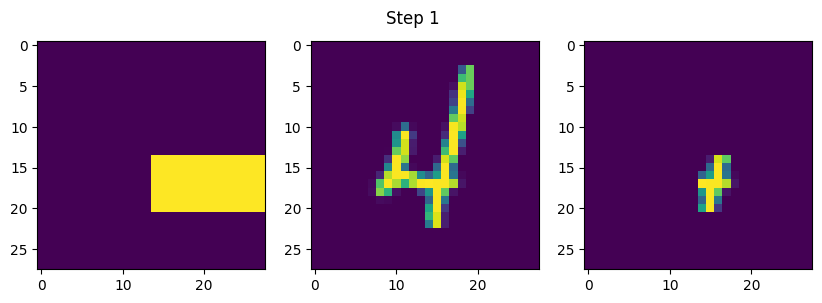


Sampled action: (2, 6)
Value estimate: -0.04288937
Distributions:
[5.1537999e-03 9.3627777e-03 9.8501116e-01 4.7224201e-04]
[6.0513392e-03 2.4061288e-08 5.9886725e-04 1.1385667e-02 7.2057122e-01
 1.4755973e-02 5.3383112e-02 1.9182412e-02 2.6917586e-03 1.7137960e-01]
Received reward -0.1 on step 2


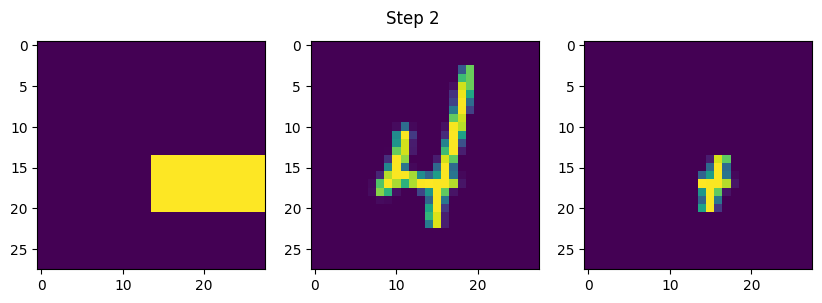


Sampled action: (2, 4)
Value estimate: -0.04288937
Distributions:
[5.1537999e-03 9.3627777e-03 9.8501116e-01 4.7224201e-04]
[6.0513392e-03 2.4061288e-08 5.9886725e-04 1.1385667e-02 7.2057122e-01
 1.4755973e-02 5.3383112e-02 1.9182412e-02 2.6917586e-03 1.7137960e-01]
Received reward 0.9 on step 3


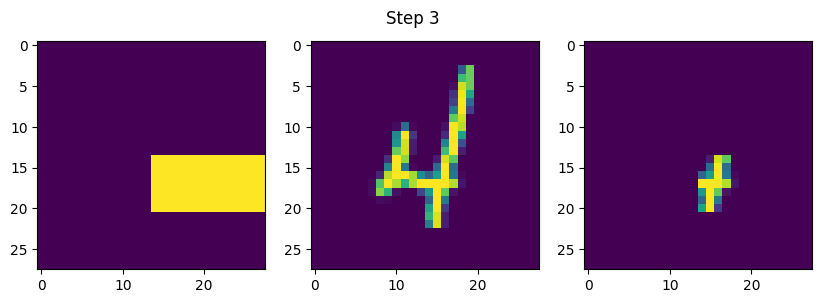


Sampled action: (2, 7)
Value estimate: 0.23035142
Distributions:
[0.2856667  0.04057237 0.65042055 0.02334034]
[1.6953393e-04 7.7049373e-07 8.8527054e-03 9.9175613e-06 1.5504262e-02
 3.6249716e-05 1.8876217e-05 7.2784758e-01 5.4008153e-05 2.4750605e-01]
Received reward 0.9 on step 1


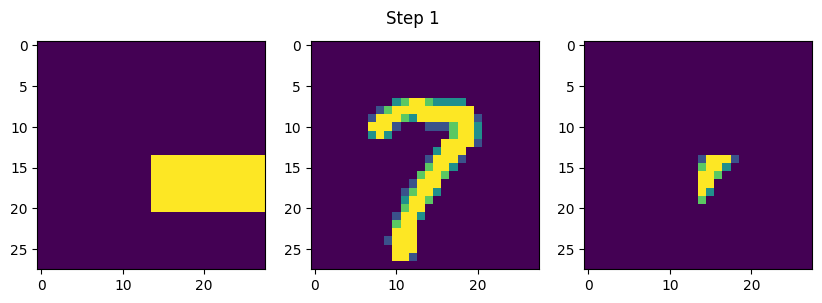


Sampled action: (2, 8)
Value estimate: 0.104878485
Distributions:
[6.4891040e-08 8.2631715e-08 9.9999994e-01 1.5558767e-08]
[5.0824137e-06 3.3357301e-13 1.4738140e-07 2.6684638e-02 7.3591031e-09
 8.2838424e-03 9.6253985e-01 3.5001385e-13 2.4862043e-03 2.2459500e-07]
Received reward -0.1 on step 1


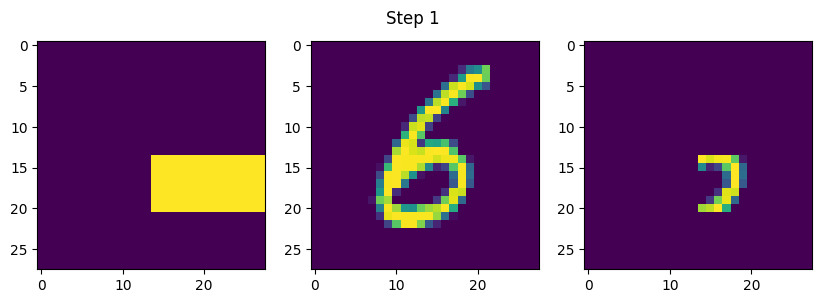


Sampled action: (2, 6)
Value estimate: 0.104878485
Distributions:
[6.4891040e-08 8.2631715e-08 9.9999994e-01 1.5558767e-08]
[5.0824137e-06 3.3357301e-13 1.4738140e-07 2.6684638e-02 7.3591031e-09
 8.2838424e-03 9.6253985e-01 3.5001385e-13 2.4862043e-03 2.2459500e-07]
Received reward 0.9 on step 2


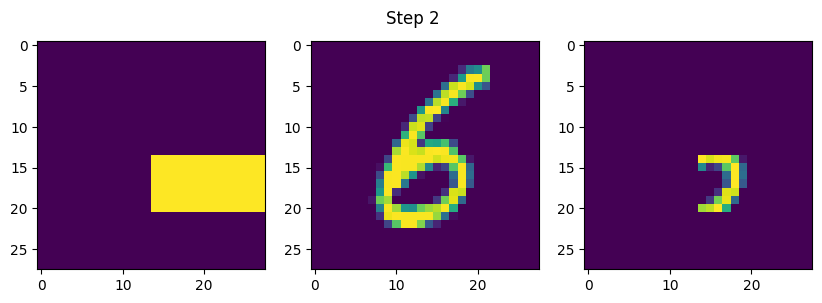


Sampled action: (2, 6)
Value estimate: 0.53543925
Distributions:
[6.3146450e-05 3.7618938e-05 9.9988908e-01 1.0100966e-05]
[5.4824492e-04 3.3745702e-09 1.4482283e-03 4.2246611e-04 5.0037423e-05
 6.5142078e-05 9.9688268e-01 1.4051318e-07 4.9606734e-04 8.6913664e-05]
Received reward 0.9 on step 1


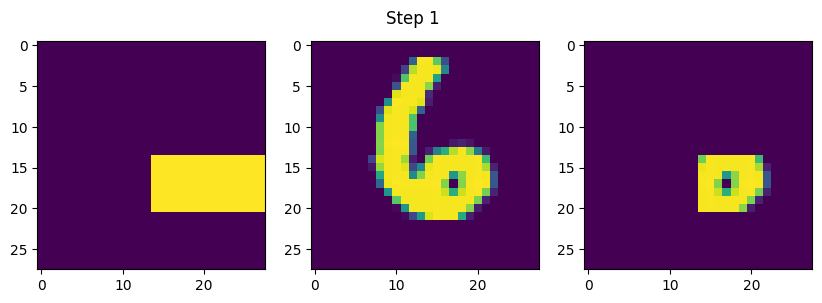

In [51]:
print("Evaluating...")
for _ in range(5):
    eval(test_agent)

In [52]:
torch.save(test_agent.model, '/kaggle/working/test_out.pt')

In [7]:
model = MNISTNet()

In [8]:
model.load_state_dict(torch.load('test_out.pt').state_dict())

<All keys matched successfully>

In [9]:
model

MNISTNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lin1): Linear(in_features=490, out_features=50, bias=True)
  (out_dir): Linear(in_features=50, out_features=4, bias=True)
  (out_digit): Linear(in_features=50, out_features=10, bias=True)
  (out_critic): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
reloaded_agent = ActorCriticNNAgent(MNISTNet, obs_to_input=obs_to_input, df=0.1)

In [11]:
reloaded_agent.model = model

In [58]:
test_agent

In [12]:
reloaded_agent

In [13]:
reloaded_agent.trainable = False

In [14]:
reloaded_agent.trainable 

False


Sampled action: (3, 1)
Value estimate: 0.6399007
Distributions:
[2.3580953e-03 1.2572142e-04 4.4295701e-04 9.9707317e-01]
[1.4086852e-07 9.9991077e-01 1.5308206e-05 2.0595426e-06 3.9234999e-07
 8.4404028e-06 3.5843587e-07 3.8514727e-06 5.7290294e-05 1.4096199e-06]
Received reward 0.9 on step 1


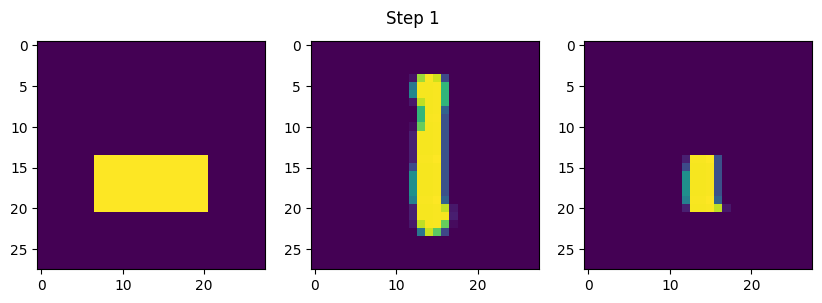

In [16]:
eval(reloaded_agent)

In [57]:
import pickle

with open('./reward.pkl', 'wb') as f:
    pickle.dump(reward, f)

In [58]:
test_reward = np.array(reward).flatten()

In [59]:
test_reward.shape[0]

100

In [66]:
test_reward

array([-0.003125,  0.38125 ,  0.503125,  0.68125 ,  0.15625 ,  0.334375,
        0.15625 ,  0.7     ,  0.39375 ,  0.69375 ,  0.390625,  0.4375  ,
        0.653125,  0.46875 ,  0.609375,  0.56875 ,  0.45625 ,  0.64375 ,
        0.846875,  0.50625 ,  0.584375,  0.675   ,  0.63125 ,  0.5875  ,
        0.721875,  0.65625 ,  0.596875,  0.621875,  0.584375,  0.65625 ,
        0.61875 ,  0.346875,  0.659375,  0.46875 ,  0.634375,  0.509375,
        0.596875,  0.39375 ,  0.590625,  0.496875,  0.384375,  0.625   ,
        0.728125,  0.85625 ,  0.715625,  0.540625,  0.7125  ,  0.715625,
        0.73125 ,  0.784375,  0.48125 ,  0.56875 ,  0.315625,  0.70625 ,
        0.765625,  0.5875  ,  0.7625  ,  0.671875,  0.5875  ,  0.446875,
        0.5375  ,  0.559375,  0.665625,  0.73125 ,  0.690625,  0.68125 ,
        0.578125,  0.615625,  0.48125 ,  0.540625,  0.64375 ,  0.621875,
        0.63125 ,  0.571875,  0.640625,  0.5125  ,  0.684375,  0.409375,
        0.715625,  0.7875  ,  0.54375 ,  0.7     , 

<function matplotlib.pyplot.show(close=None, block=None)>

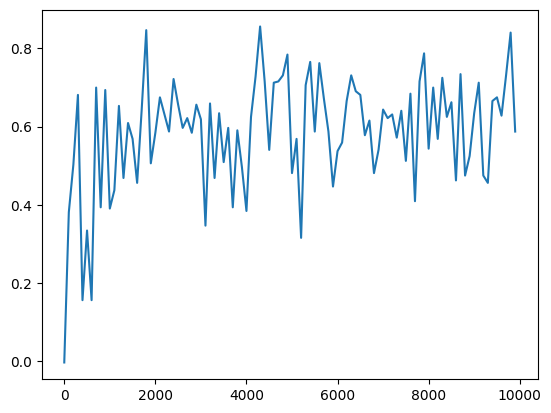

In [70]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,10000,100), test_reward)
plt.show

In [3]:
import pickle

with open('reward.pkl', 'rb') as f:
    loaded_reward = pickle.load(f)

loaded_reward = np.array(loaded_reward).flatten()
print('final iteration reward:', loaded_reward[-1])
print('final mean iteration reward:', np.mean(loaded_reward))


final iteration reward: 0.5874999999999999
final mean iteration reward: 0.58625


In [4]:
print('Peak reward:', np.max(loaded_reward))

Peak reward: 0.8562500000000001


In [14]:
class q_learning():
    def __init__(self, Q=None, alpha=0.1, gamma=0.9, epsilon=1, epsilon_min=0.1, epsilon_decay=0.995, num_episode=32):                
        # Q-learning parameters
        self.Q = Q
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.num_episodes = num_episode

    def train(self, iterations=10000):

        env = MNISTEnv(type='train')

        # Initialize Q-table
        Q = np.zeros((env.h, env.w, 40))  # State-action space
        rewards = []    
        mean_reward_100 = []
        mean_reward_32 = []
        reward_32 = []
        for episode in range(self.num_episodes*iterations):
            # print each 100 iterations (100*32)
            display = True if episode%3200 == 0 else False
            
            save = True if episode%32 == 0 else False
            # print 
            state = env.reset()
            total_reward = 0
            
            done = False
            while not done:
                
                h, w = env.pos
                if np.random.rand() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q[h, w])
                
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                
                next_h, next_w = env.pos
                best_next_action = np.argmax(Q[next_h, next_w])
                Q[h, w, action] = Q[h, w, action] + self.alpha * (reward + self.gamma * Q[next_h, next_w, best_next_action] - Q[h, w, action])
                
                state = next_state
            
            mean_reward_100.append(total_reward)
            mean_reward_32.append(total_reward)
            
            if save:
                if episode == 0:
                    reward
            
            if display:
                if episode==0:
                    print(f"Episode 0, total mean reward: 0")
                    rewards.append(0)
                else:
                    current_mean_100_reward = np.mean(np.array(mean_reward_100))
                    print(f"From episode {int((episode/32))-99} to {int(episode/32)}, total mean reward: {current_mean_100_reward}")
                    rewards.append(current_mean_100_reward)
                    mean_reward_100 = []
                
            epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        self.Q = Q    
        print("Training finished.")
        
        return rewards
        


    def eval(self):
        env = MNISTEnv(type='test')
        
        # Evaluation
        num_test_episodes = 1000
        reward_total = 0
        success_count = 0
        for _ in range(num_test_episodes):
            state = env.reset()
            done = False
            while not done:
                h, w = env.pos
                action = np.argmax(self.Q[h, w])
                state, reward, done, _ = env.step(action)
                reward_total += reward
                if done and reward > 0:
                    success_count += 1

        print(f"Average reward on 1000 test iterations:{reward_total/1000}")
        print(f"Success rate: {success_count / num_test_episodes * 100}%")
        
    def test(self):
        env = MNISTEnv(type='test')
        state = env.reset()
        reward_total = 0
        step = 0
        
        done = False
        while not done:
            step += 1
            h, w = env.pos
            action = np.argmax(self.Q[h, w])
            state, reward, done, _ = env.step(action)
            print('Action reward:', reward)
            env.render()
            
            reward_total += reward
            
            if step==20: break

        print(f"Total reward:{reward_total}")

In [45]:
q_learn = q_learning()
reward = q_learn.train()

Episode 0, total mean reward: 0
From episode 0 to 100, total mean reward: -0.04873477038425497
From episode 100 to 200, total mean reward: -0.03528125000000006
From episode 200 to 300, total mean reward: -0.028187500000000067
From episode 300 to 400, total mean reward: -0.011937500000000063
From episode 400 to 500, total mean reward: -0.014750000000000062
From episode 500 to 600, total mean reward: 0.0072187499999999535
From episode 600 to 700, total mean reward: -0.013750000000000056
From episode 700 to 800, total mean reward: 0.037156249999999946
From episode 800 to 900, total mean reward: -0.012562500000000058
From episode 900 to 1000, total mean reward: 0.012374999999999943
From episode 1000 to 1100, total mean reward: 0.011968749999999946
From episode 1100 to 1200, total mean reward: -0.001750000000000057
From episode 1200 to 1300, total mean reward: -0.02331250000000006
From episode 1300 to 1400, total mean reward: 0.01462499999999995
From episode 1400 to 1500, total mean reward:

In [46]:
reward = np.array(reward)

In [47]:
reward.shape

(100,)

<function matplotlib.pyplot.show(close=None, block=None)>

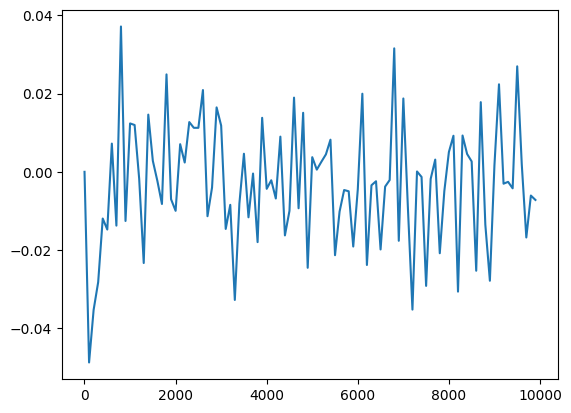

In [49]:
plt.plot(np.arange(1,10000,100), reward)
plt.show

In [50]:
reward[-1]

-0.007187500000000057

In [51]:
np.mean(reward)

-0.0031657852038426055

In [54]:
import pickle
with open('./qlearn_reward.pkl', 'wb') as f:
    pickle.dump(reward, f)

In [55]:
with open('./qlearn_policy.pkl', 'wb') as f:
    pickle.dump(q_learn.Q, f)

In [8]:
import pickle
with open('./qlearn_policy.pkl', 'rb') as f:
    q_poli = pickle.load(f)
    

In [4]:
q_poli.shape

(4, 4, 40)

In [6]:
import numpy as np

<function matplotlib.pyplot.show(close=None, block=None)>

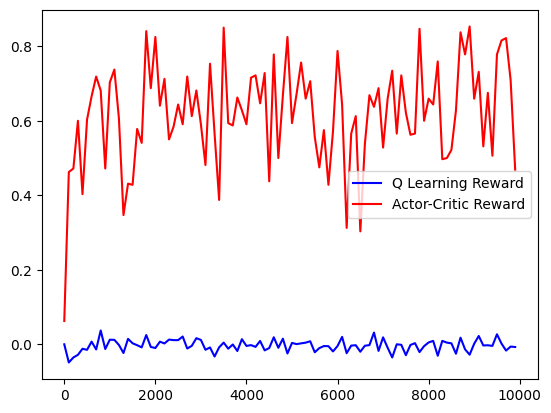

In [10]:
with open('./qlearn_reward.pkl', 'rb') as f:
    qlearn_reward = pickle.load(f)
    
with open('./actor_reward.pkl', 'rb') as f:
    actor_reward = pickle.load(f)
    
import matplotlib.pyplot as plt
plt.plot(np.arange(1,10000,100), qlearn_reward, label='Q Learning Reward', color='b')
plt.plot(np.arange(1,10000,100), actor_reward, label='Actor-Critic Reward', color='r')
plt.legend()
plt.show

In [15]:
q_learn = q_learning(q_poli)
q_learn.test()

Average reward on 1000 test iterations:-1.070000000000141
Success rate: 33.800000000000004%


In [18]:
def qlearn_test(model):
    env = MNISTEnv(type='test')
    state = env.reset()
    reward_total = 0
    step = 0
    
    done = False
    while not done:
        step += 1
        h, w = env.pos
        action = np.argmax(model.Q[h, w])
        state, reward, done, _ = env.step(action)
        print('Action reward:', reward)
        env.render()
        
        reward_total += reward
        
        if step==20: break

    print(f"Total reward:{reward_total}")

Action reward: -0.1


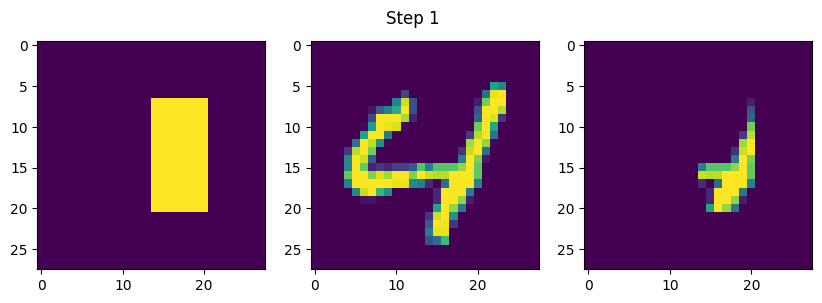

Action reward: -0.1


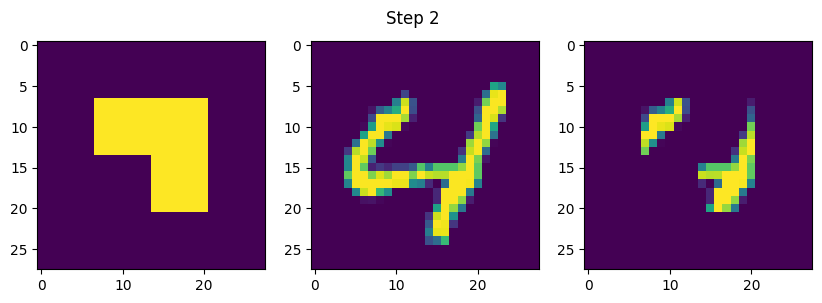

Action reward: -0.1


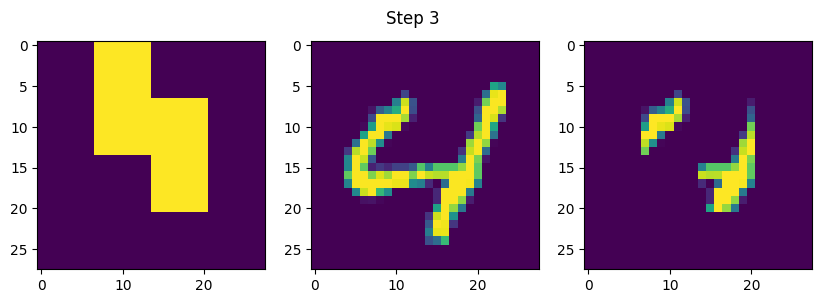

Action reward: -0.1


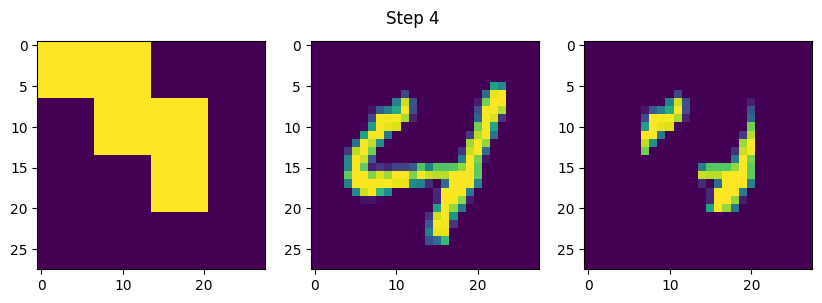

Action reward: -0.1


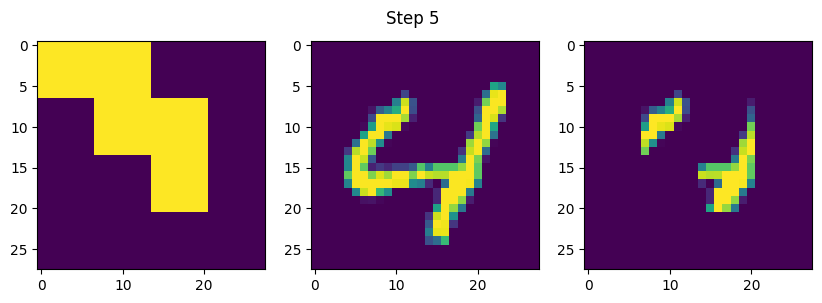

Action reward: -0.1


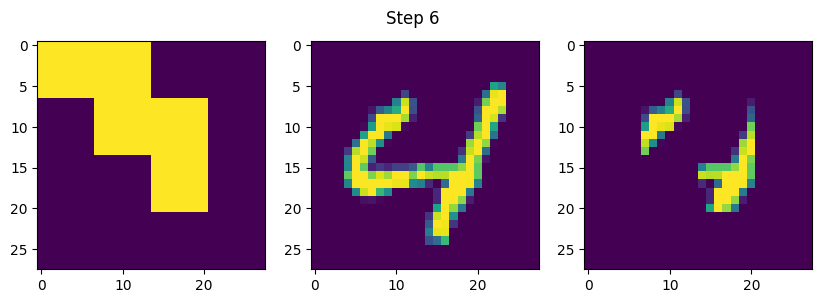

Action reward: -0.1


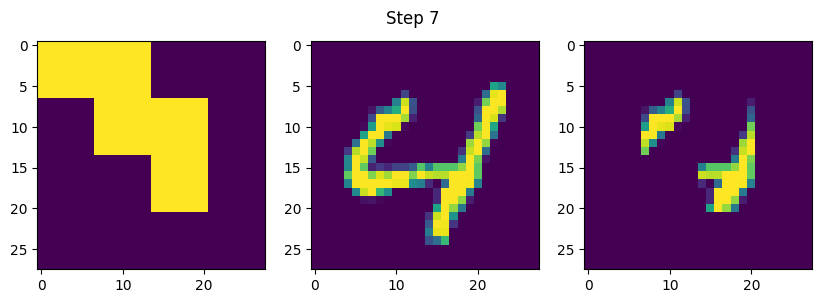

Action reward: -0.1


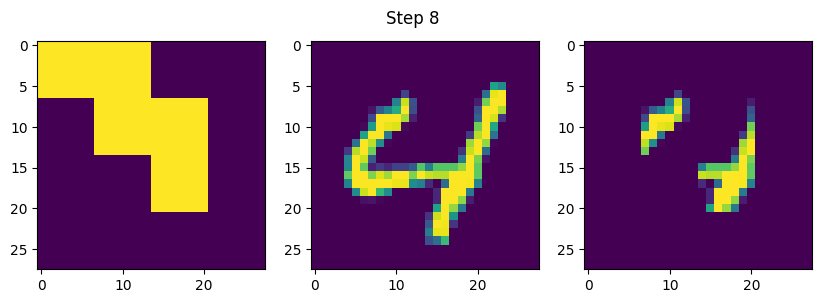

Action reward: -0.1


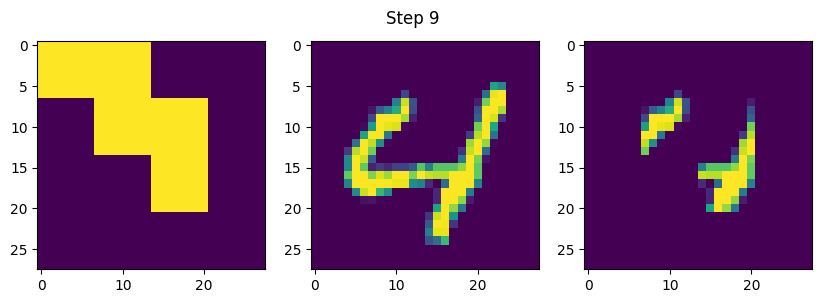

Action reward: -0.1


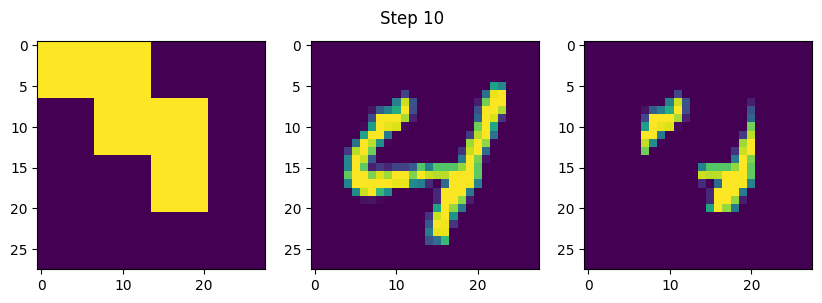

Action reward: -0.1


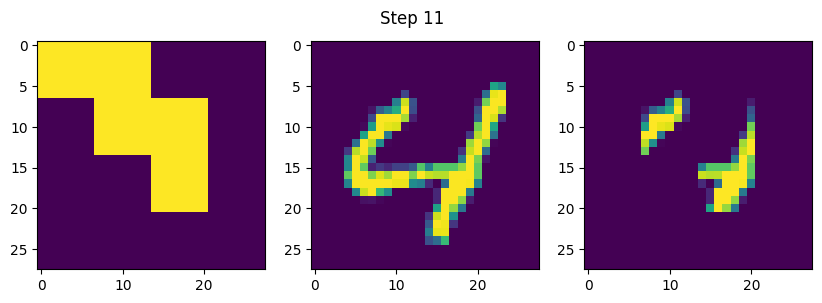

Action reward: -0.1


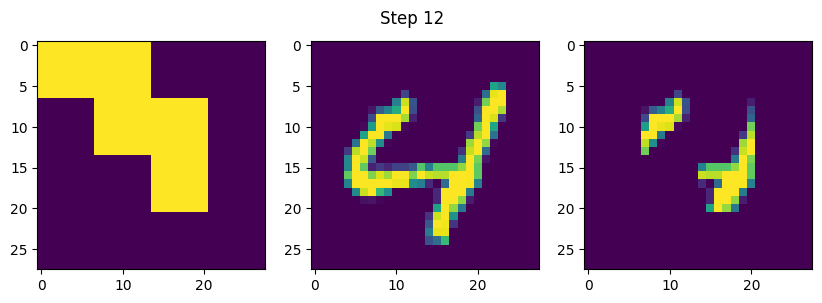

Action reward: -0.1


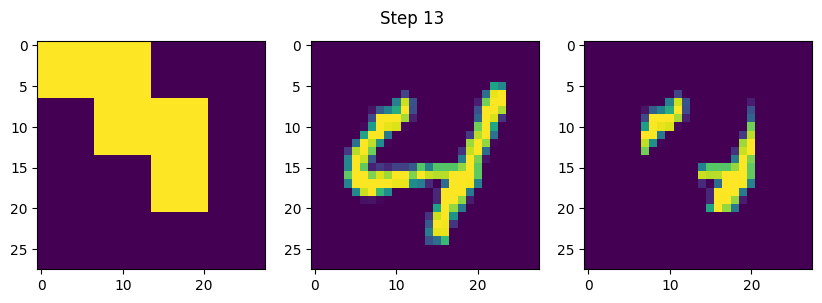

Action reward: -0.1


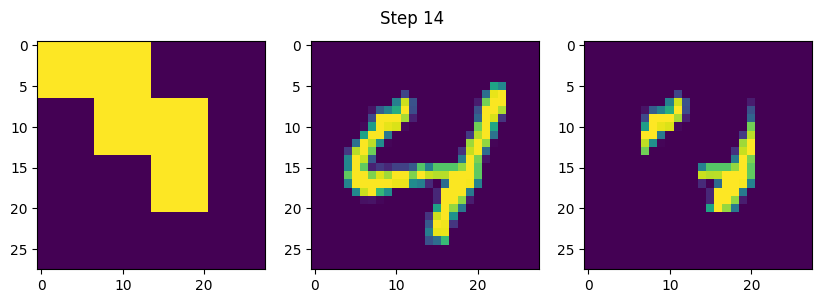

Action reward: -0.1


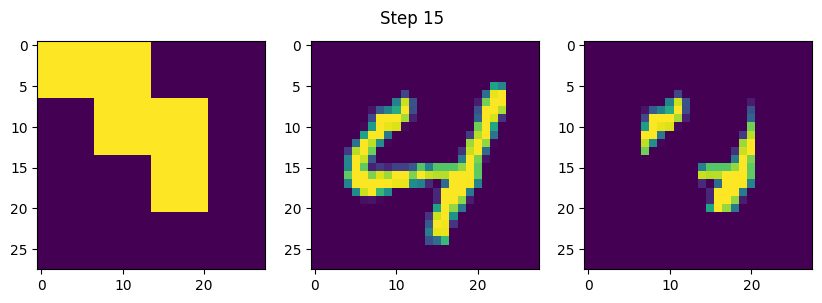

Action reward: -0.1


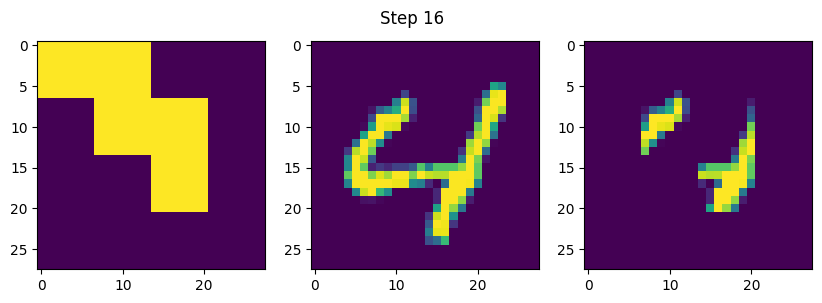

Action reward: -0.1


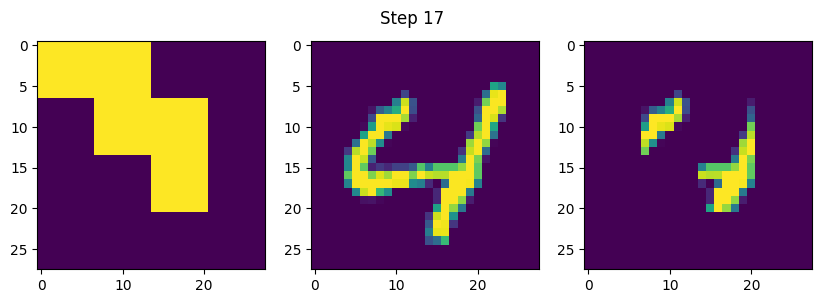

Action reward: -0.1


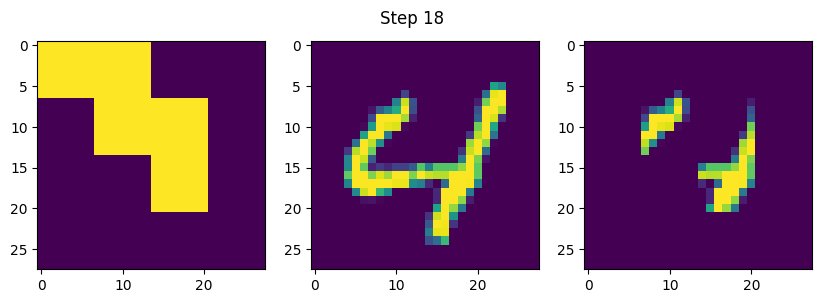

Action reward: -0.1


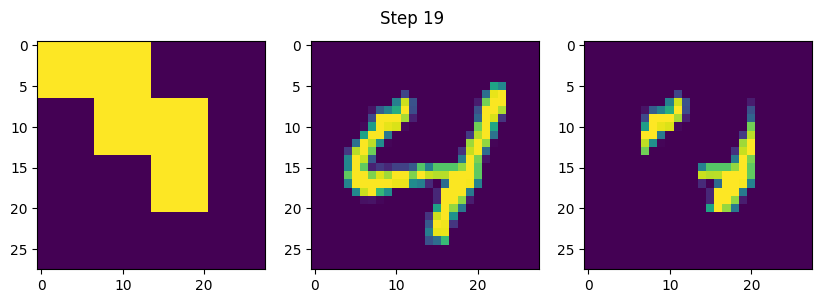

Action reward: -0.1


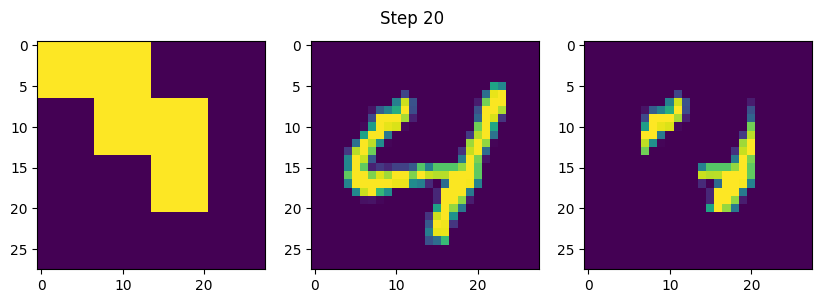

Total reward:-2.0000000000000004


In [19]:
qlearn_test(q_learn)